In [1]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from gp_diffscales import AladynSurvivalModeldiffKernels, compute_smoothed_prevalence


%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/tensornoulli_ehr_new/data"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'event_for_aladynoulli.rds')))
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))

E = E.astype(int)

# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)
G_tensor = torch.FloatTensor(G)

# Get dimensions
N, D, T = Y_tensor.shape
P = G_tensor.shape[1]
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 10  # number of topics

# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"G: {G_tensor.shape}")  # [N, P]
print(f"Time range: 0 to {T-1}")
print(T)

G shape after transposition: (9661, 36)
Tensor shapes:
Y: torch.Size([9661, 348, 51])
E: torch.Size([9661, 348])
G: torch.Size([9661, 36])
Time range: 0 to 50
51


In [2]:
prevalence_t = compute_smoothed_prevalence(Y, window_size=5)

# Initialize model
model = AladynSurvivalModeldiffKernels(N, D, T, K, P, G, Y, prevalence_t)

# Train model
history = model.fit(
    event_times=E,
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2,
    convergence_threshold=0.1,
    patience=20
)



Epoch 0
Loss: 3351878.2500
Lambda length scales: [12.374002  19.99163   10.09627   12.370599  17.826614   6.2363205
 12.845501  18.082293  24.032743  18.82093  ]
Phi length scales: [21.814674 12.382373  9.671158 16.204016 21.337336 17.7454   17.074707
  6.88301  12.368466 19.933159]
Lambda amplitudes: [1.0010005 1.0010005 1.0010005 1.0010005 1.0010005 1.0010005 1.0010005
 1.0010005 1.0010005 1.0010005]
Phi amplitudes: [1.0010005 1.0010005 1.0010005 1.0010005 1.0010005 1.0010005 1.0010005
 1.0010005 1.0010005 1.0010005]
Max gradients - λ: 97.4071, φ: 84.0412, γ: 482.6190
Mean condition numbers - λ: 6802.24, φ: 6490.44
Loss change: inf

Epoch 100
Loss: 1156616.8750
Lambda length scales: [12.279327 19.893723 10.001983 12.275784 17.729042  6.148923 12.750872
 17.98462  23.934914 18.723156]
Phi length scales: [21.716574 12.28817   9.577097 16.110033 21.239107 17.647491 16.977503
  6.790106 12.27297  19.835009]
Lambda amplitudes: [1.1071292 1.1082826 1.1070683 1.1072073 1.1081687 1.1049832 

In [6]:
857757.1250-803012.6250

54744.5

In [ ]:
857757.1250

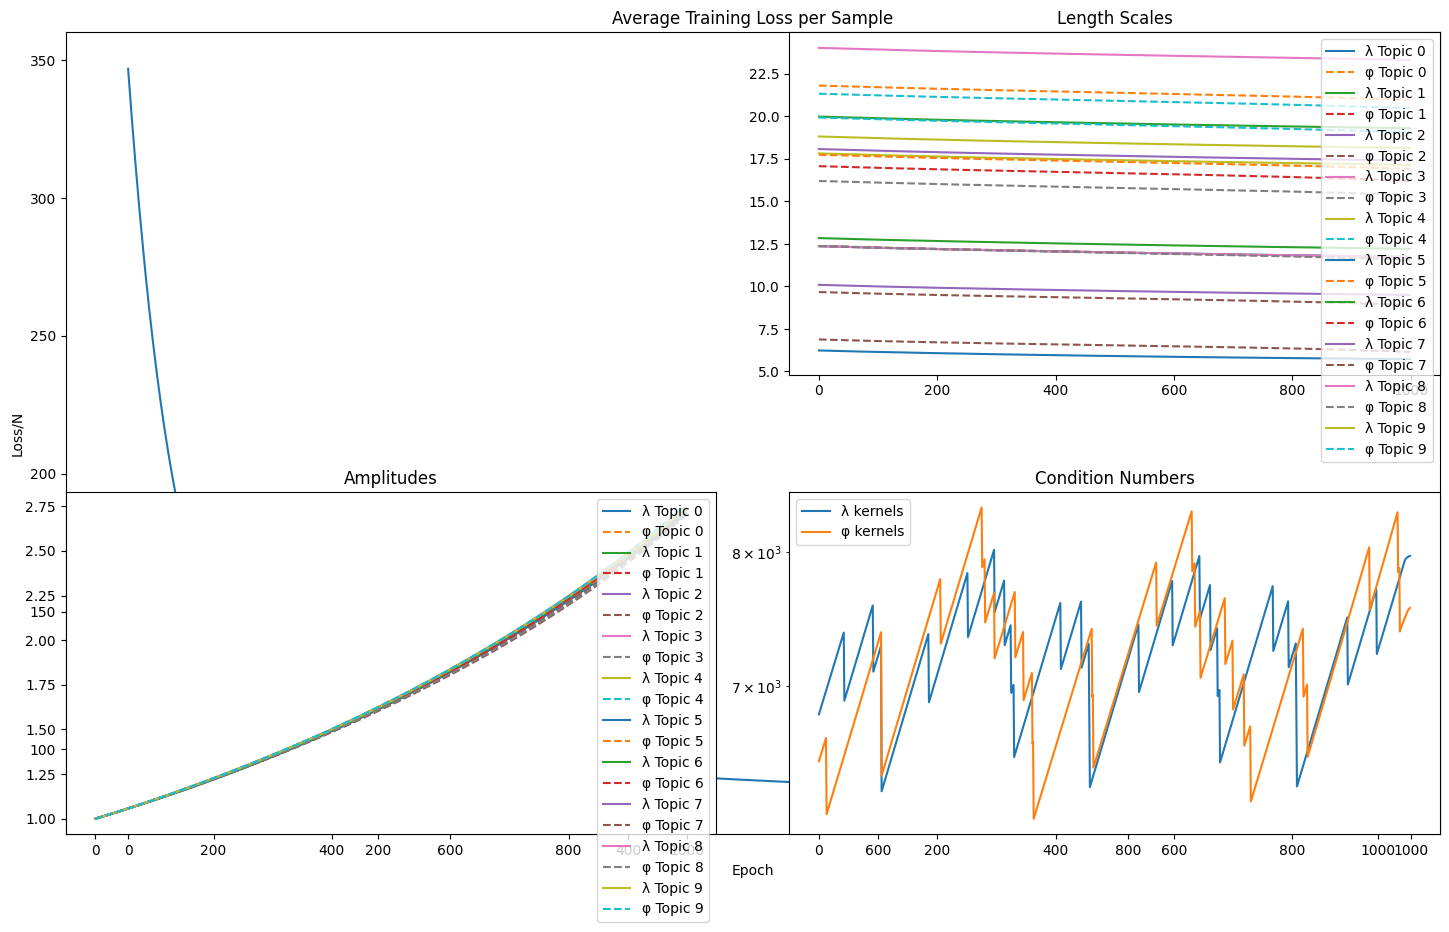

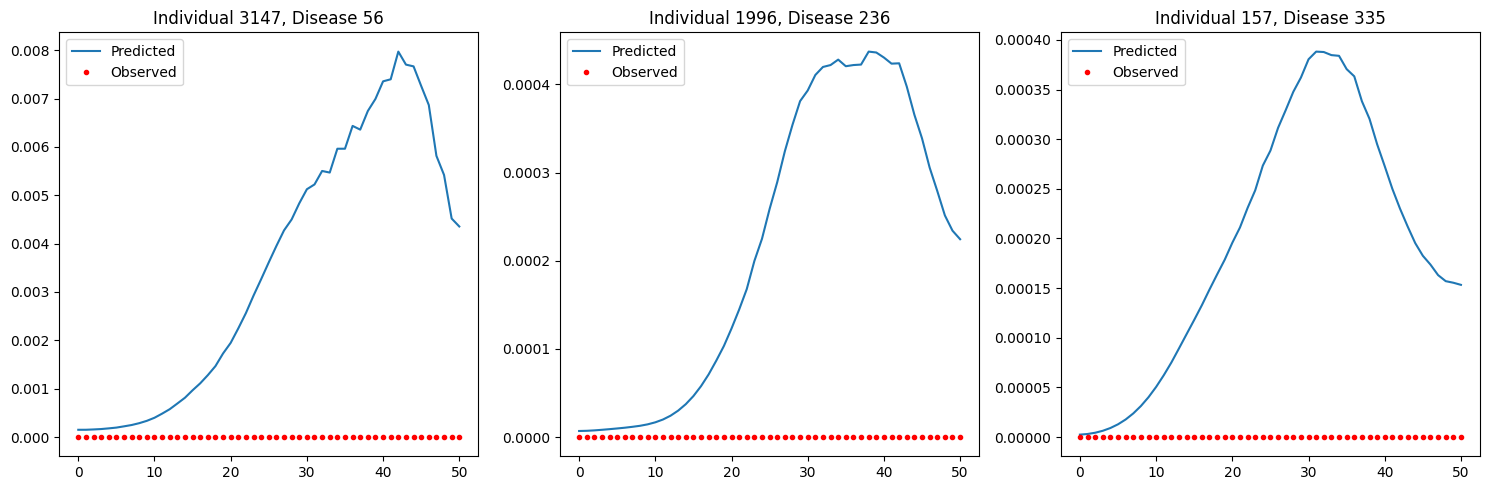

In [11]:

# Plot training diagnostics
def plot_training_diagnostics(history):
    plt.figure(figsize=(15, 10))
    
   
    
    N = model.N  # Get number of samples from the model
    avg_loss = [loss/N for loss in history['loss']]

    plt.plot(avg_loss)
   
    plt.title('Average Training Loss per Sample')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/N')
    
    # Plot length scales
    plt.subplot(2, 2, 2)
    for k in range(K):
        plt.plot(np.array(history['lambda_length_scales'])[:, k], 
                label=f'λ Topic {k}')
        plt.plot(np.array(history['phi_length_scales'])[:, k], 
                '--', label=f'φ Topic {k}')
    plt.title('Length Scales')
    plt.legend()
    
    # Plot amplitudes
    plt.subplot(2, 2, 3)
    for k in range(K):
        plt.plot(np.array(history['lambda_amplitudes'])[:, k], 
                label=f'λ Topic {k}')
        plt.plot(np.array(history['phi_amplitudes'])[:, k], 
                '--', label=f'φ Topic {k}')
    plt.title('Amplitudes')
    plt.legend()
    
    # Plot condition numbers
    plt.subplot(2, 2, 4)
    plt.plot(history['condition_number_lambda'], label='λ kernels')
    plt.plot(history['condition_number_phi'], label='φ kernels')
    plt.yscale('log')
    plt.title('Condition Numbers')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot diagnostics
plot_training_diagnostics(history)

# Get predictions
with torch.no_grad():
    pi_pred, theta_pred, phi_pred = model.forward()
    pi_pred = pi_pred.numpy()

# Plot some random predictions
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    n = np.random.randint(0, N)
    d = np.random.randint(0, D)
    plt.plot(pi_pred[n, d], label='Predicted')
    plt.plot(Y[n, d], 'r.', label='Observed')
    plt.title(f'Individual {n}, Disease {d}')
    plt.legend()
plt.tight_layout()
plt.show()


Prediction Statistics:
--------------------------------------------------
Events (n=14005):
  Mean = 0.0152
  Std  = 0.0098

Non-events (n=2449550):
  Mean = 0.0071
  Std  = 0.0080


NameError: name 'ks_2samp' is not defined

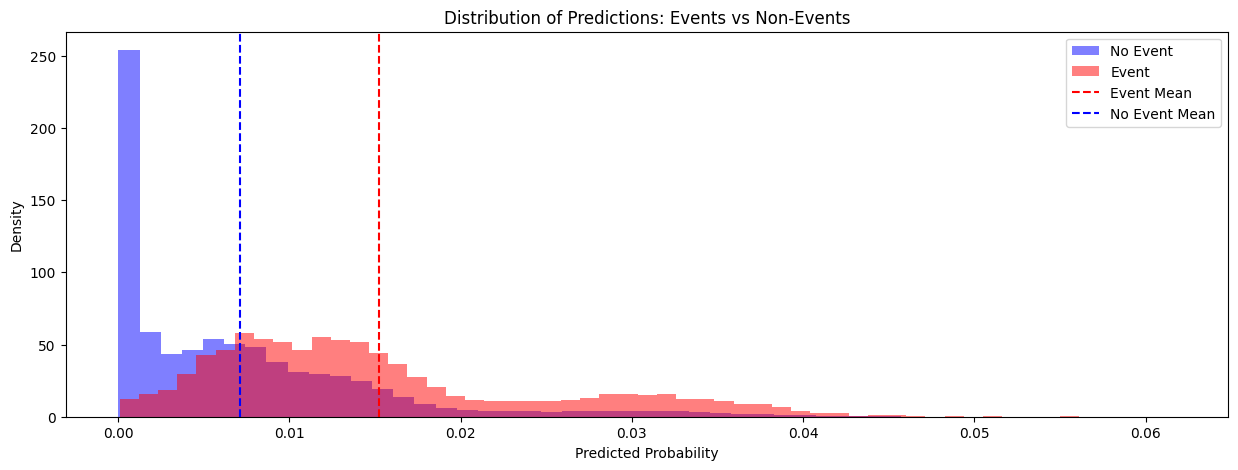

In [4]:
def plot_prediction_distributions(Y, pi_pred, n_top_diseases=5):
    """
    Plot distribution of predictions for events vs non-events
    for the diseases with the most events
    """
    N, D, T = Y.shape
    
    # Find diseases with most events
    disease_events = np.sum(np.any(Y, axis=2), axis=0)
    top_diseases = np.argsort(-disease_events)[:n_top_diseases]
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Aggregate predictions and true values across top diseases
    all_preds_event = []
    all_preds_nonevent = []
    
    for d in top_diseases:
        # Get predictions and true values for this disease
        pred_d = pi_pred[:,d,:].flatten()  # Model predictions
        true_d = Y[:,d,:].flatten()        # True values
        
        # Make sure dimensions match
        assert len(pred_d) == len(true_d), f"Mismatch in disease {d}: pred={len(pred_d)}, true={len(true_d)}"
        
        # Separate predictions for events and non-events
        all_preds_event.extend(pred_d[true_d == 1])
        all_preds_nonevent.extend(pred_d[true_d == 0])
    
    # Plot distributions
    plt.hist(all_preds_nonevent, bins=50, alpha=0.5, 
             density=True, label='No Event', color='blue')
    plt.hist(all_preds_event, bins=50, alpha=0.5, 
             density=True, label='Event', color='red')
    
    # Add mean lines
    if len(all_preds_event) > 0:
        plt.axvline(np.mean(all_preds_event), color='red', 
                   linestyle='--', label='Event Mean')
    plt.axvline(np.mean(all_preds_nonevent), color='blue', 
                linestyle='--', label='No Event Mean')
    
    # Add labels
    plt.title('Distribution of Predictions: Events vs Non-Events')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()
    
    # Print statistics
    
    print("\nPrediction Statistics:")
    print("-" * 50)
    if len(all_preds_event) > 0:
        print(f"Events (n={len(all_preds_event)}):")
        print(f"  Mean = {np.mean(all_preds_event):.4f}")
        print(f"  Std  = {np.std(all_preds_event):.4f}")
    
    print(f"\nNon-events (n={len(all_preds_nonevent)}):")
    print(f"  Mean = {np.mean(all_preds_nonevent):.4f}")
    print(f"  Std  = {np.std(all_preds_nonevent):.4f}")
    
    # Calculate separation metrics
    if len(all_preds_event) > 0:
        ks_stat = ks_2samp(all_preds_event, all_preds_nonevent)
        print(f"\nKS test:")
        print(f"  Statistic = {ks_stat.statistic:.4f}")
        print(f"  p-value = {ks_stat.pvalue:.4e}")
    
    plt.show()

# Get model predictions
with torch.no_grad():
    pi_pred = model.forward()[0].numpy()

# Run the analysis
plot_prediction_distributions(Y, pi_pred)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_67564/4267676013.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


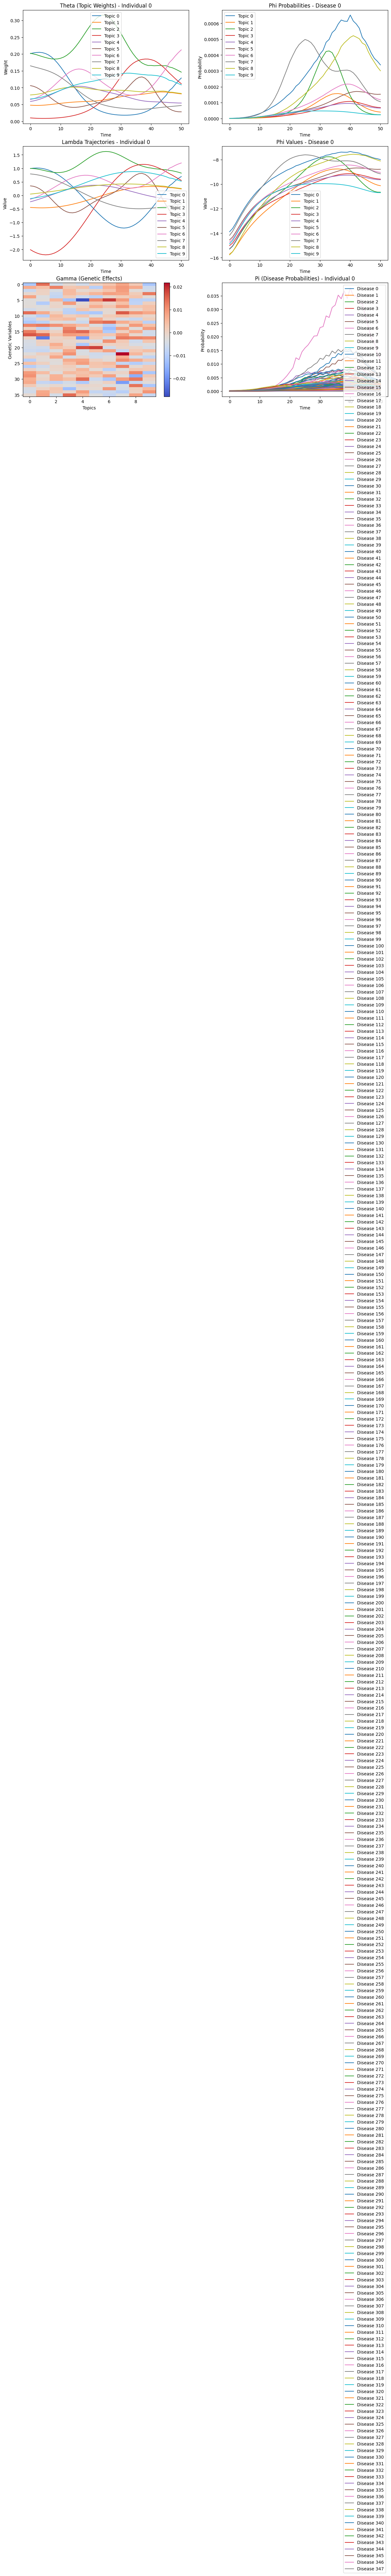

In [5]:
K=10
pi_pred, theta_pred, phi_pred = model.forward()

# Plot predicted theta only
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(3, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()



plt.tight_layout()
plt.show()


